In [1]:
#| default_exp fid

The course video relevant to this notebook is lesson 21: 24 minnk

Link: https://en.wikipedia.org/wiki/Matrix_sign_function

Caveats regarding FID
1. It is dependent upon the number of samples used.  The lower the number of samples the higher the FID score
2. When used in papers the models were based upon images of 296x296 and from Inception
3. Papers base things against the Inception baseline, it is more useful to use your own models that have been trained to be specifically aimed at the domain that is being investigated, however these are not then directly comparable to the FID numbers in papers

The KID metric (Kernal Inception Distance) is independent of image and sample size, however, it has a lot of variance and has not generally been found to be useful

## FID 

In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [4]:

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=7

## Classifier 

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
b = xb,yb = next(iter(dls.train))

In [7]:
cbs = [DeviceCB(), MixedPrecision()]
model = torch.load('/home/models/data_aug2.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

There are two ways to generate features from a specific layer in the model.  One is to use hooks (demonstrated below), the other is to truncate the model at a certain point and simply take the outputs at that point

In [8]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [9]:
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [10]:
learn.fit(1, train=False, cbs=[hcb])

In [11]:
feats = hcb.hooks

In [12]:
len(feats)

1

In [13]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [14]:
del(learn.model[8])
del(learn.model[7])

In [15]:
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## Calculate FID 

In [16]:
# Define the usual diffusion parameters
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [17]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [18]:
def collate_ddpm(b): 
    """ given a batch of data apply noisify to the image part. Pass in alphabar
    """
    return noisify(default_collate(b)[xl], alphabar)

In [19]:
def dl_ddpm(ds): 
    """ Create a ddpm dataloader using the above collate function, which in turn uses default
    collate to return a batch of images and targets as tensors in a tuple
    """
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [20]:
# Create an updated dataloader using the above data loader applied to the datasets 
# with transforms
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

Since the UNet2DModel needs both the image and the timestep we need to modify the way we pass data into it (our dataloader passes out one tuple).  We can do this with the fudge below, that is inheriting the class but modifying the forward method to split the tuple into to variables and feed these forwards

In [21]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [22]:
# Load the trained diffusion model
smodel = torch.load('/home/models/fashion_ddpm_mp.pkl').cuda()

In [23]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    """ Create a function to generate a number of samples from the model
    args
        sz: number of samples to generate.  Should be a tuple 
            of (num images, channels, height, width)
        alpha: array of alpha values vs timestep
        alphabar: array of alphbar values vs timestep
        sigma: array of sigmas vs timestep
        n_steps: the number of steps to use in the generation process
    """
    device = next(model.parameters()).device
    # Generate random images as starting point
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        # create array of values of t for each image to failitate broadcasting
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        # Generate new random noise for this step
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_0_hat.cpu())
    return preds

In [24]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 40.4 s, sys: 622 ms, total: 41 s
Wall time: 40.9 s


In [25]:
# Take the final sample of each image
s = samples[-1]

In [26]:
s[0].mean(), s[0].std()

(tensor(0.15), tensor(0.28))

In [27]:
# I believe this is to try and get the range of the images into the same range as 
# the inputs to the image classifier when it sees images from mnist
s = s*2-1

In [28]:
s[0].mean(), s[0].std()

(tensor(-0.70), tensor(0.57))

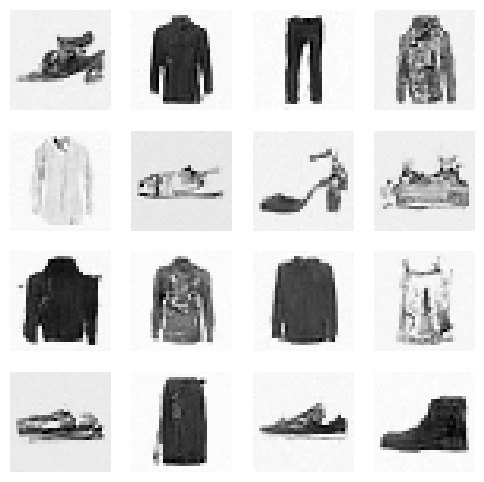

In [29]:
show_images(s[:16], imsize=1.5)

Now create a learner that will pass the images through the classifier.  We have to pass in the targets as well but this can be anything as its not used.  We are not training and so don't
need an optimiser or loss function.  Capture preds will pass the entire validation set through the model and return the predictions as well as the (irrelevant) targets

In [30]:
clearn = TrainLearner(model, DataLoaders([],[(s,yb)]), loss_func=fc.noop, cbs=[DeviceCB()], 
                      opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

This has generated one 512 feature vector for each image

In [31]:
# Take the mean across the feature generated by passing mnist images through the classifier
# (FID is for overall sets of images and not individual images)
means = feats.mean(0)
means.shape

torch.Size([512])

In [32]:
# Generate the covariance matrix of the vector against itself.  Note that the covariance
# function requires the rows to be the variables and the columns to be the observations 
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [33]:
feats.T.shape

torch.Size([512, 10000])

In [34]:
#|export
def _sqrtm_newton_schulz(mat, num_iters=100):
    """ This is the way to generate the square root of a matrix in an iterative manner
    It is not actually used but the  scipy library contains this function and that is used
    instead
    """
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat/mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters):
        T = (3*I - Z@Y)/2
        Y,Z = Y@T,T@Z
        res = Y*mat_nrm.sqrt()
        if ((mat-(res@res)).norm()/mat_nrm).abs()<=1e-6: break
    return res

In [35]:
#|export
def _calc_stats(feats):
    """ calculate the mean and co-variance of the features.  The covariance defines the
    relative linkage of different features
    """
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [36]:
s1,s2 = _calc_stats(feats),_calc_stats(feats2)

In [37]:
_calc_fid(*s1, *s2)

40.89117431640625

In [38]:
#|export
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

In [39]:
#|export
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [40]:
_calc_kid(feats, feats2)

0.12233797460794449

## FID class 

In [42]:
#|export
class ImageEval:
    """ Class to calculate FID and KID.  In both cases the model should be a classifier
    or similar that is trained to catagorise images.  The sample passed to the fid or kid 
    methods should be the generated images|
    """
    def __init__(self, model, dls, cbs=None):
        """ 
        """
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

Calculate FID and KID for the samples generated above

In [43]:
ie = ImageEval(model, dls, cbs=[DeviceCB()])

In [44]:
%%time
ie.fid(s)

CPU times: user 1.08 s, sys: 2.19 s, total: 3.27 s
Wall time: 595 ms


40.96942138671875

Explore how the FID score changes through the generation process

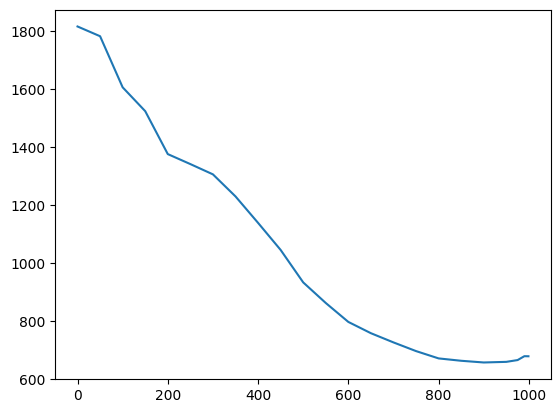

In [53]:
xs = L.range(0, 1000, 50) +[975, 990, 999]
plt.plot(xs, [ie.fid(samples[i].clamp(-0.5, 0.5)*2) for i in xs])

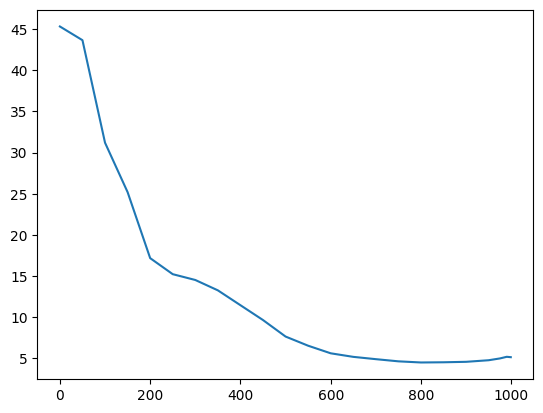

In [54]:
xs = L.range(0, 1000, 50) +[975, 990, 999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5, 0.5)*2) for i in xs])

Explore passing in a batch of real images

In [56]:
len(xb)

512

In [57]:
ie.fid(xb)

5.92633056640625

In [58]:
ie.kid(xb)

-0.015781013295054436

## Inception 

In [60]:
from pytorch_fid.inception import InceptionV3

In [64]:
class InceptionWrap(nn.Module):
    """ Class to wrap the inception model.  The only function of to repeat the input
    channels and to set it to resize the input (to the value usually expected, around 290)
    """
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat(1,3,1,1))[0]

In [65]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [66]:
# Use the inception model as the feature generator.  Note that this creates three 
# input channels since inception expects a color model
ie = ImageEval(InceptionWrap(), dls, cbs=[DeviceCB()])

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [67]:
%%time
ie.fid(s)

CPU times: user 19.8 s, sys: 17.2 s, total: 37 s
Wall time: 6.35 s


60.67002868652344

In [68]:
ie.fid(xb)

27.914154052734375

In [69]:
%%time
ie.kid(s)

CPU times: user 1.92 s, sys: 353 ms, total: 2.27 s
Wall time: 516 ms


0.009413480758666992

In [70]:
ie.kid(xb)

-8.641590102342889e-05

## Export -


In [72]:
import nbdev; nbdev.nbdev_export()